# **Imports**

In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL, MSTL
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
import holidays
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# **Data preparation & feature engineering**

Model-specific extension of predictive_analytics_dataPrep.ipynb

In [2]:
# Read in .csv files
df1 = pd.read_csv("FINAL1.csv", index_col='datetime', parse_dates=['datetime'])
df2 = pd.read_csv("FINAL2.csv", index_col='datetime', parse_dates=['datetime'])

# Add holiday information to the data set
us_holidays = holidays.US()
df1['is_holiday'] = df1.index.to_series().apply(lambda x: 1 if x in us_holidays else 0)
df2['is_holiday'] = df1.index.to_series().apply(lambda x: 1 if x in us_holidays else 0)

# Split the data set along the right data ranges
df1 = df1[df1.index >= '2018-09-06 00:00:00']
df1 = df1[df1.index < '2020-03-01 00:00:00']
datasets = [df1, df2]

# Create pandas.Series with the index & target values
df1_index_target = df1[['total minutes of parking']]
df2_index_target = df2[['total minutes of parking']]

In [3]:
# Define size of test/training data
training_size = 0.8

# Split df1
split_point = int(len(df1_index_target) * training_size)
df1_train = df1[:split_point]
df1_test = df1[split_point:]

# Split df2
split_point = int(len(df2_index_target) * training_size)
df2_train = df2[:split_point]
df2_test = df2[split_point:]

In [4]:
# Create columns that include transformed data
df1_train['transformed_data'] = df1_train['total minutes of parking'].map(lambda x: np.sqrt(x))
df2_train['transformed_data'] = df2_train['total minutes of parking'].map(lambda x: np.sqrt(x))

C:\Users\Felix\AppData\Local\Temp\ipykernel_9144\3271189019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_train['transformed_data'] = df1_train['total minutes of parking'].map(lambda x: np.sqrt(x))
C:\Users\Felix\AppData\Local\Temp\ipykernel_9144\3271189019.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_train['transformed_data'] = df2_train['total minutes of parking'].map(lambda x: np.sqrt(x))


# **Plot data**

## Plot data | Site 1

<Axes: xlabel='datetime'>

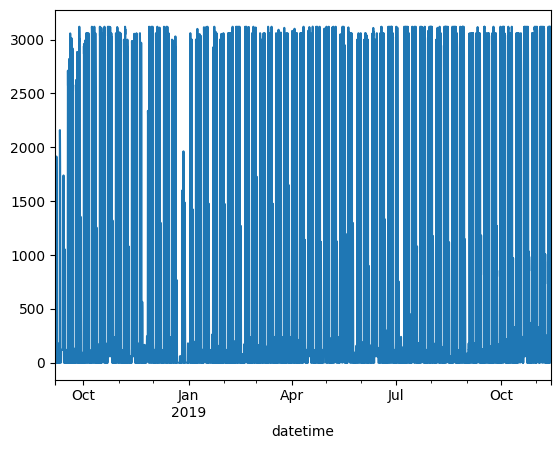

In [5]:
df1_train['total minutes of parking'].plot()

## Plot data | Site 2

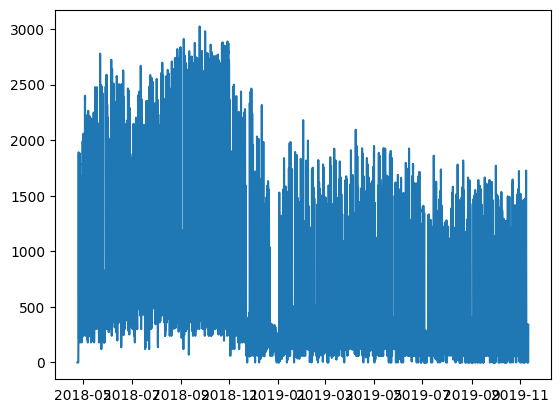

In [6]:
plt.plot(df2_train['total minutes of parking'])

# **STL Decomposition**

Method from the time series worksheet is being used to test data for stationarity. <br>
Window size for calculation of the rolling mean/std has been adjusted to this specific data set.

In [7]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24*30).mean()
    rolstd = timeseries.rolling(window=24*30).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:\n')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

## STL Decomposition | Site 1

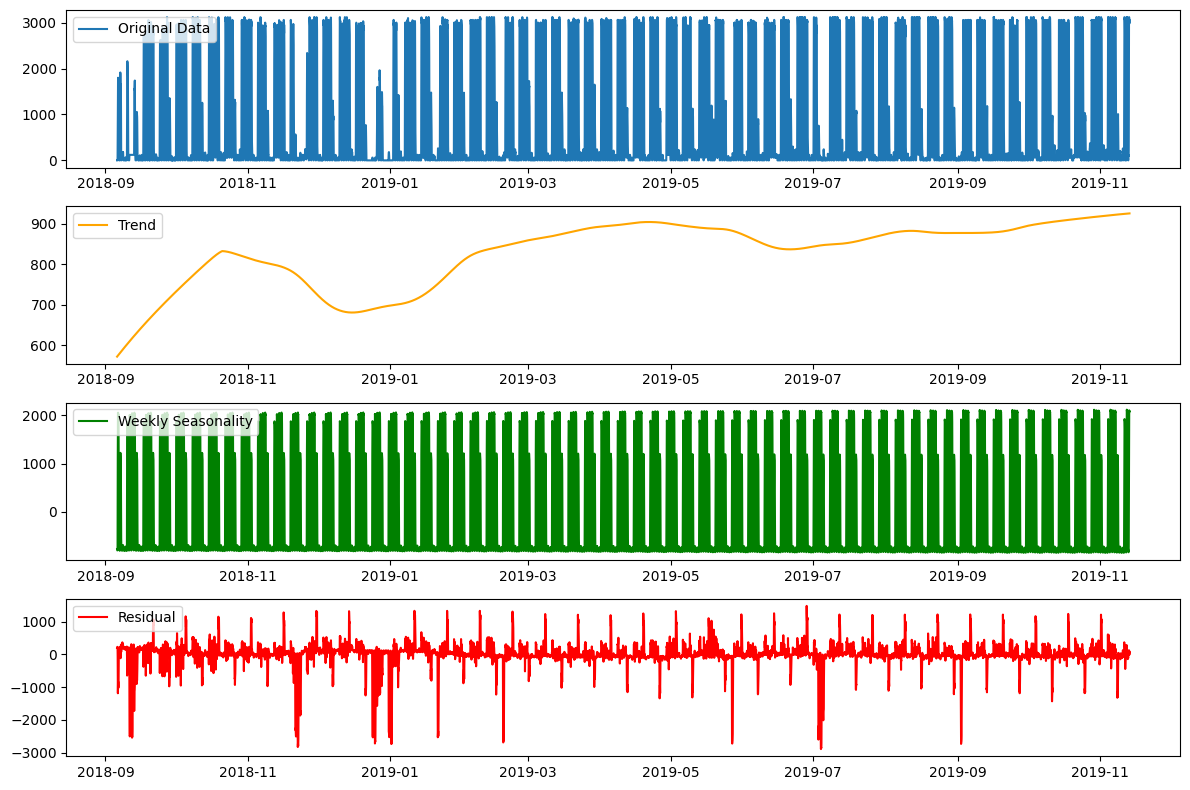

In [8]:
# Define input for STL decomposition
stl_input_df = df1_train[['total minutes of parking']]

# Apply STL for weekly seasonality
stl_model = STL(stl_input_df, period=24*7, seasonal=101, trend= 24*30*3+1, seasonal_deg=0)
stl_result = stl_model.fit()

# Extract components
stl_trend = stl_result.trend
stl_seasonal_w = stl_result.seasonal
stl_residual_wow = stl_result.resid

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(stl_input_df, label="Original Data")
plt.legend(loc="upper left")

plt.subplot(4, 1, 2)
plt.plot(stl_input_df.index, stl_trend, label="Trend", color="orange")
plt.legend(loc="upper left")

plt.subplot(4, 1, 3)
plt.plot(stl_input_df.index, stl_seasonal_w, label="Weekly Seasonality", color="green")
plt.legend(loc="upper left")

plt.subplot(4, 1, 4)
plt.plot(stl_input_df.index, stl_residual_wow, label="Residual", color="red")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

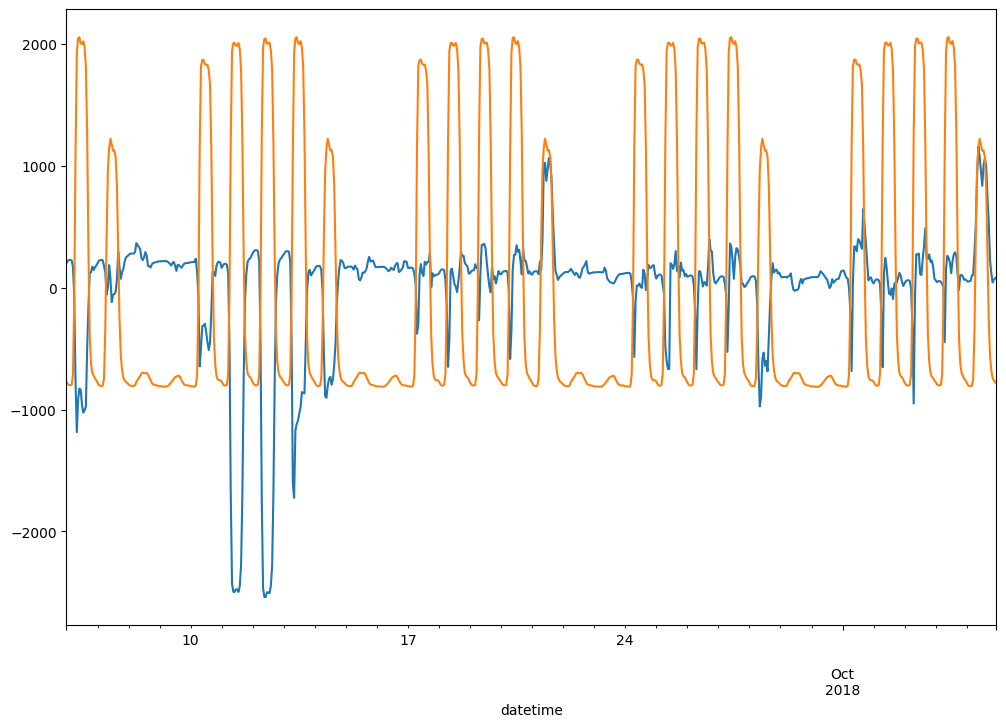

In [9]:
# Detailed inspection of residuals and seasonality
plt.rcParams["figure.figsize"] = (12,8)
stl_residual_wow[:24*30].plot();
stl_seasonal_w[:24*30].plot();

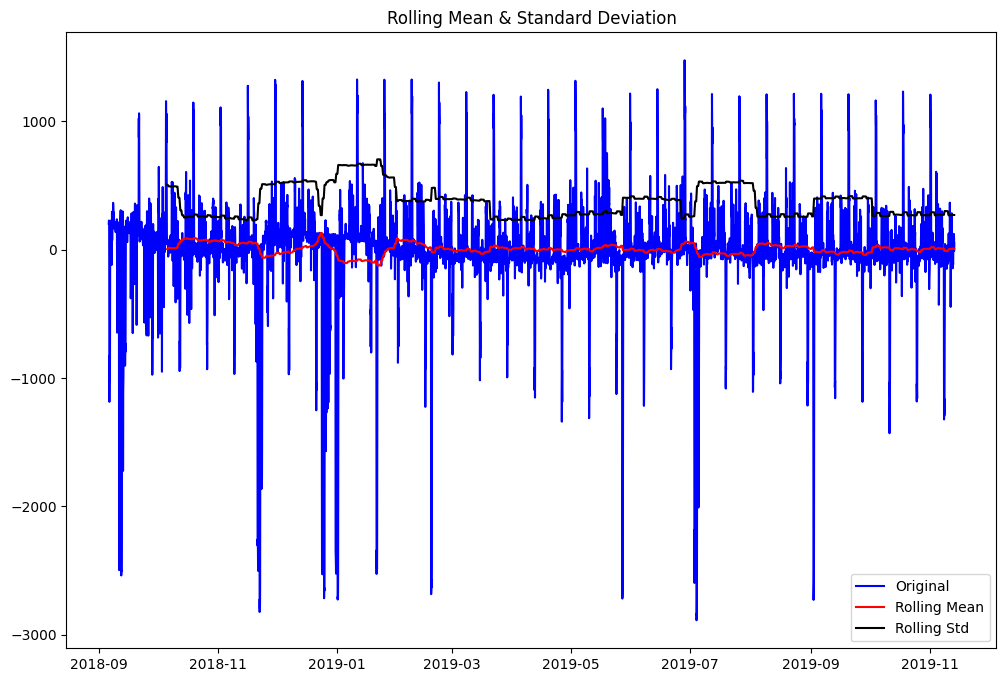

Results of Dickey-Fuller Test:

Test Statistic                -1.189073e+01
p-value                        5.877349e-22
#Lags Used                     3.800000e+01
Number of Observations Used    1.036700e+04
Critical Value (1%)           -3.430981e+00
Critical Value (5%)           -2.861819e+00
Critical Value (10%)          -2.566918e+00
dtype: float64


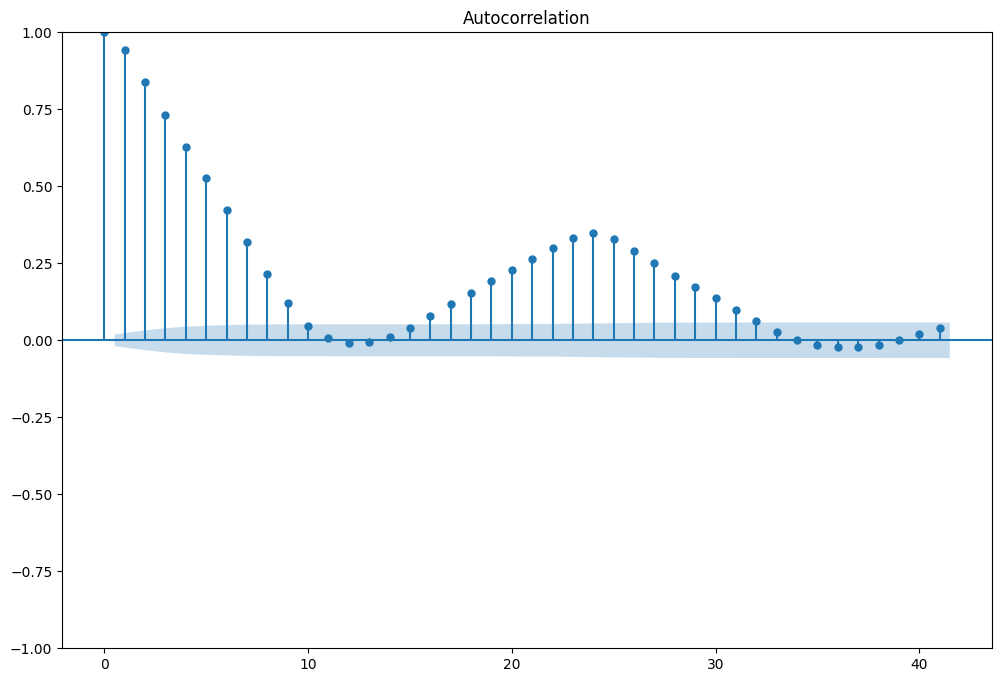

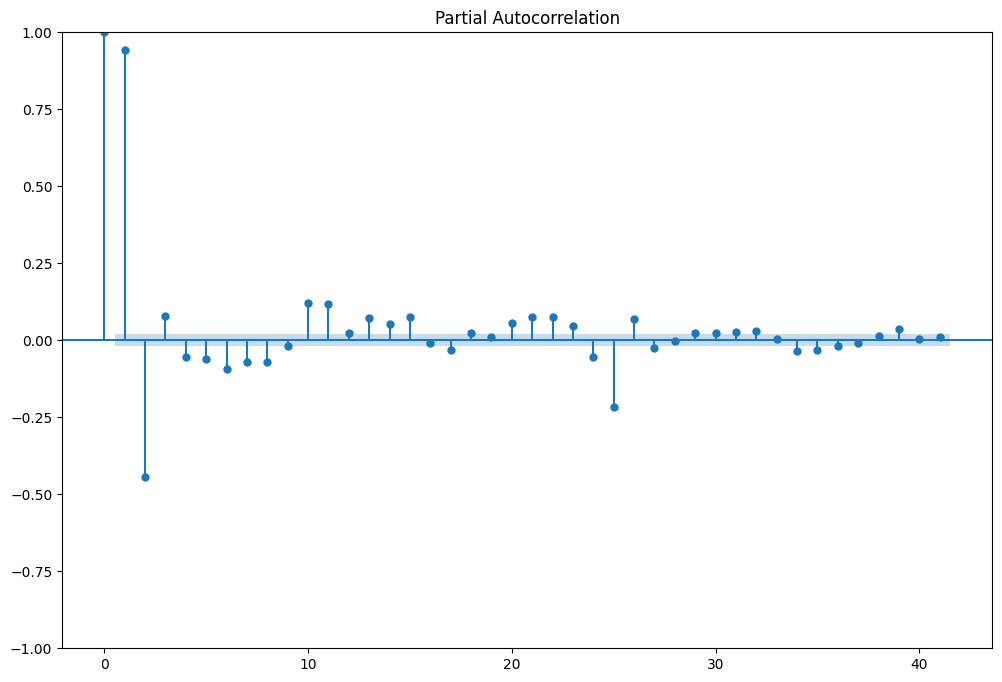

In [10]:
test_residual = stl_residual_wow
test_stationarity(test_residual)
plot_acf(test_residual)
plot_pacf(test_residual);

## STL Decomposition | Site 2

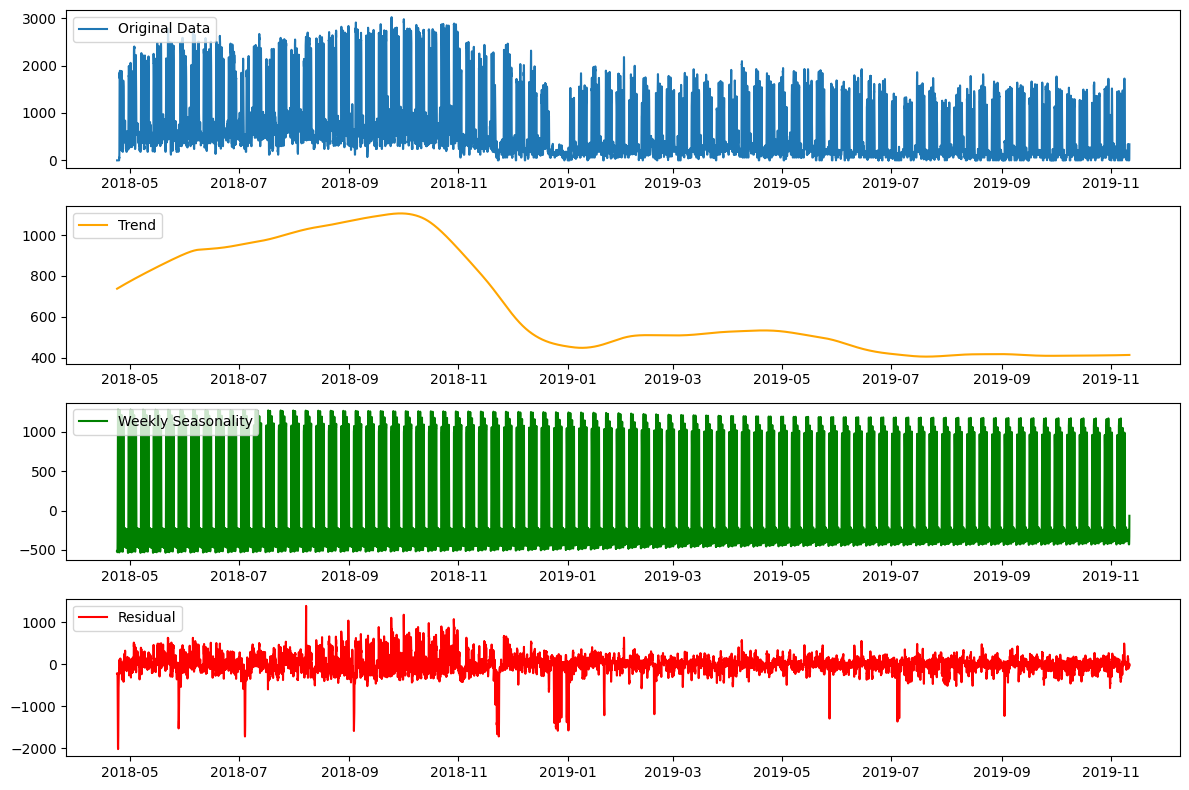

In [11]:
# Define input for STL decomposition
stl_input_df2 = df2_train[['total minutes of parking']]

# Apply STL for weekly seasonality
stl_model_df2 = STL(stl_input_df2, period=24*7, seasonal=101, trend= 24*30*3+1, seasonal_deg=0)
stl_result_df2 = stl_model_df2.fit()

# Extract components
stl_trend_df2 = stl_result_df2.trend
stl_seasonal_w_df2 = stl_result_df2.seasonal #Weekly seasonality
stl_residual_wow_df2 = stl_result_df2.resid #Residual without weekly (wow) pattern

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(stl_input_df2, label="Original Data")
plt.legend(loc="upper left")

plt.subplot(4, 1, 2)
plt.plot(stl_input_df2.index, stl_trend_df2, label="Trend", color="orange")
plt.legend(loc="upper left")

plt.subplot(4, 1, 3)
plt.plot(stl_input_df2.index, stl_seasonal_w_df2, label="Weekly Seasonality", color="green")
plt.legend(loc="upper left")

plt.subplot(4, 1, 4)
plt.plot(stl_input_df2.index, stl_residual_wow_df2, label="Residual", color="red")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

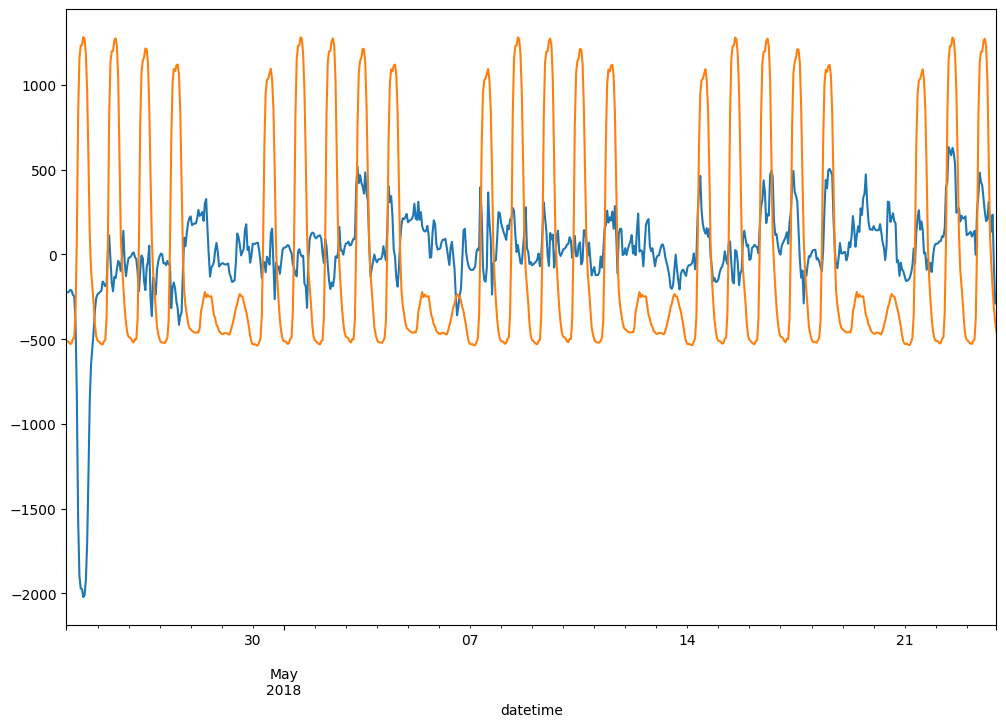

In [12]:
# Detailed inspection of residuals and seasonality
plt.rcParams["figure.figsize"] = (12,8)
stl_residual_wow_df2[:24*30].plot();
stl_seasonal_w_df2[:24*30].plot();

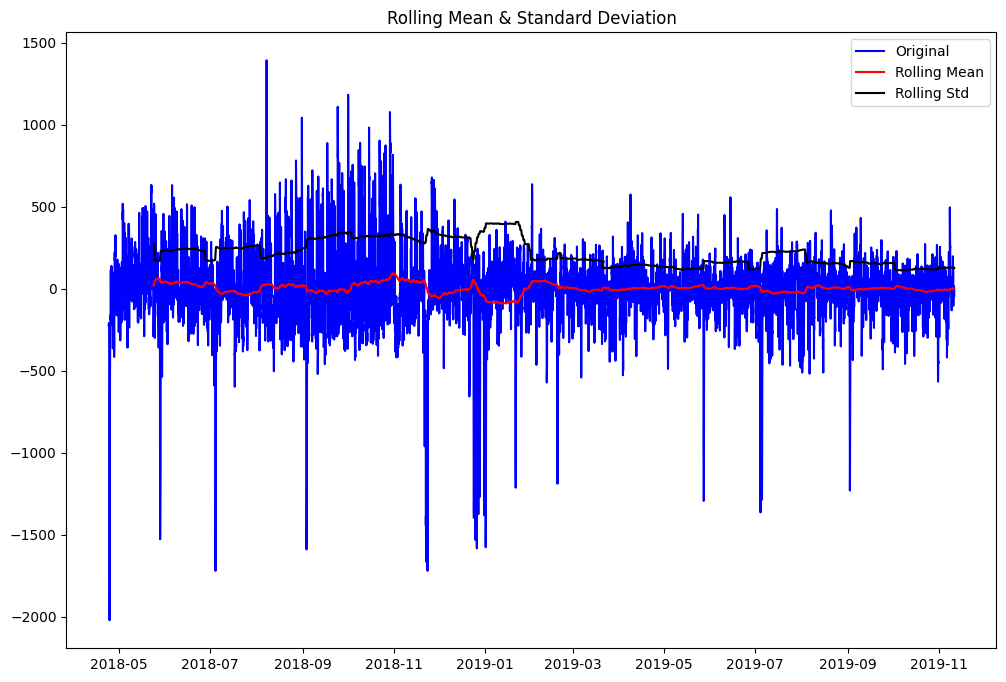

Results of Dickey-Fuller Test:

Test Statistic                -1.360504e+01
p-value                        1.920584e-25
#Lags Used                     4.100000e+01
Number of Observations Used    1.355100e+04
Critical Value (1%)           -3.430833e+00
Critical Value (5%)           -2.861753e+00
Critical Value (10%)          -2.566884e+00
dtype: float64


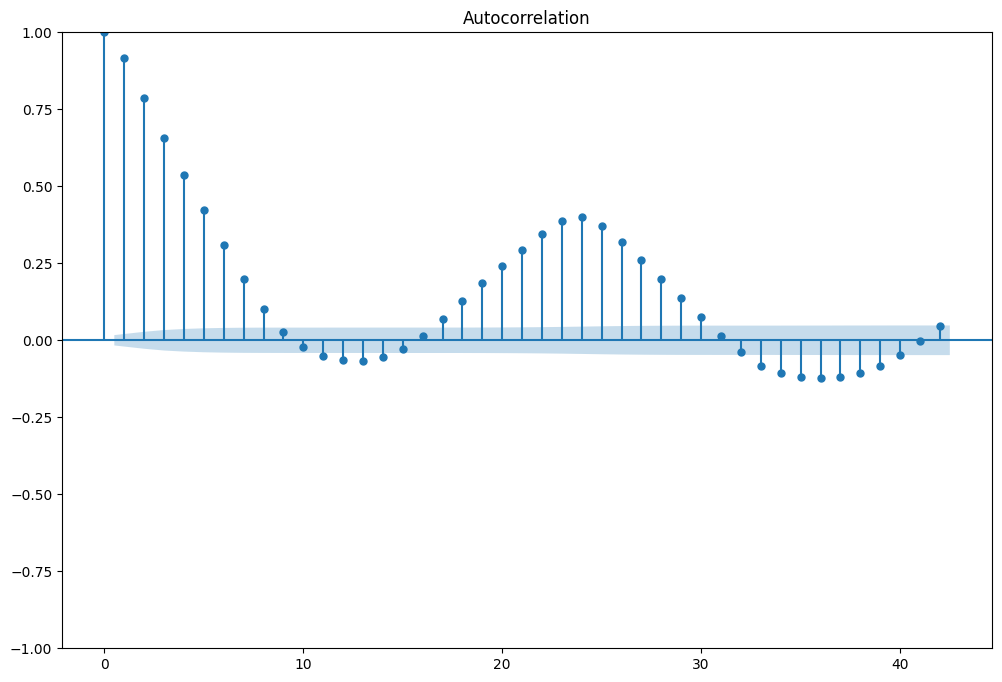

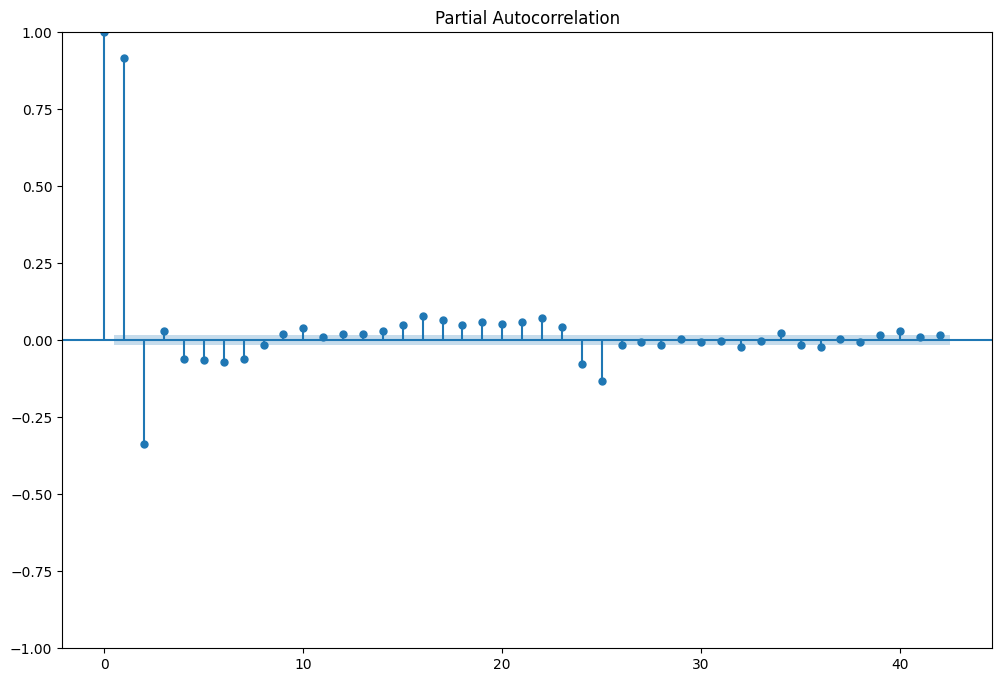

In [13]:
test_residual = stl_residual_wow_df2
test_stationarity(test_residual)
plot_acf(test_residual)
plot_pacf(test_residual);

# **SARIMAX model**

## SARIMAX model | Site 1

In [14]:
# Define the SARIMAX input data
sarimax_input_df = stl_residual_wow

# Define the exogenos variables
exog = df1_train[['is_holiday']]

In [15]:
# Grid search for best SARIMAX model
# Excluding seasonality for the grid search, due to computational limitations
stepwise_model = auto_arima(y=sarimax_input_df,
                            # m=24,
                            X=exog,
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            seasonal=False, trace=True,
                            error_action='ignore', suppress_warnings=True)

c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was ren

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=129319.406, Time=4.77 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=153415.208, Time=1.68 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=131508.246, Time=1.99 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=142212.058, Time=3.21 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=129137.992, Time=4.71 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=129215.324, Time=3.85 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=129217.969, Time=10.69 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=129170.694, Time=10.77 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=129164.313, Time=8.13 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=129151.219, Time=6.51 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=129780.326, Time=11.84 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=129139.935, Time=8.07 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 76.271 seconds


In [16]:
# Create SARIMAX model
sarimax_model = SARIMAX(sarimax_input_df, exog=exog, order=(3,0,5), seasonal_order=(1,1,1,24), freq='h')
sarimax_result = sarimax_model.fit()

c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## SARIMAX model | Site 2

In [17]:
# Define the SARIMAX input data
sarimax_input_df2 = stl_residual_wow_df2

# Define the exogenos variables
exog = df2_train[['is_holiday']]

In [18]:
# Grid search for best SARIMAX model
# Excluding seasonality for the grid search, due to computational limitations
stepwise_model = auto_arima(y=sarimax_input_df2,
                            #m=24, 
                            X=exog,
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            seasonal=False, trace=True,
                            error_action='ignore', suppress_warnings=True)

c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was ren

Performing stepwise search to minimize aic


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=160694.751, Time=5.47 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=186140.266, Time=1.80 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=162281.390, Time=1.86 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=173037.345, Time=4.01 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=160608.250, Time=6.72 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=160623.431, Time=3.85 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=161041.642, Time=1.88 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=160831.987, Time=15.36 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=160627.239, Time=7.82 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=160613.596, Time=7.06 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=160882.534, Time=14.72 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=160610.105, Time=10.37 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 81.148 seconds


In [19]:
# Create SARIMAX model
sarimax_model_df2 = SARIMAX(sarimax_input_df2, exog=exog, order=(2,0,2), seasonal_order=(1,1,1,24), freq='h')
sarimax_result_df2 = sarimax_model_df2.fit()

c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Forecast

## Forecast | Site 1

Forecast Trend with linear regression

In [20]:
def predict_trend(stl_trend, forecast_horizon):

    X = range(0, len(stl_trend))
    y = stl_trend

    lin_reg_df = pd.DataFrame({'Hours': X, 'Trend':y})

    X = lin_reg_df[['Hours']].values
    y = lin_reg_df['Trend'].values

    lin_reg_model = LinearRegression().fit(X,y)

    future_time = np.arange(len(stl_trend), len(stl_trend) + forecast_horizon).reshape(-1,1)
    future_trend = lin_reg_model.predict(future_time)

    return future_trend

In [21]:
# Define forecast horizon
forecast_horizon = 24*90
forecast_index = pd.date_range(start=df1_train.index[-1], periods=forecast_horizon + 1, freq="h")[1:]

# Define holidays for forecast horizon
exog_holidays = forecast_index.to_series().apply(lambda x: 1 if x in us_holidays else 0)

# Forecast residuals
residual_model = sarimax_result
forecast_residual = residual_model.forecast(steps=forecast_horizon, exog=exog_holidays)

# Forecast weekly pattern
forecast_weekly = stl_seasonal_w[-168:] 
forecast_weekly = np.tile(forecast_weekly, int(np.ceil(forecast_horizon / 168)))[:forecast_horizon]

# Forecast trend 
forecast_trend = predict_trend(stl_trend, forecast_horizon)

forecast = forecast_residual + forecast_weekly + forecast_trend
forecast = forecast.clip(lower=0)

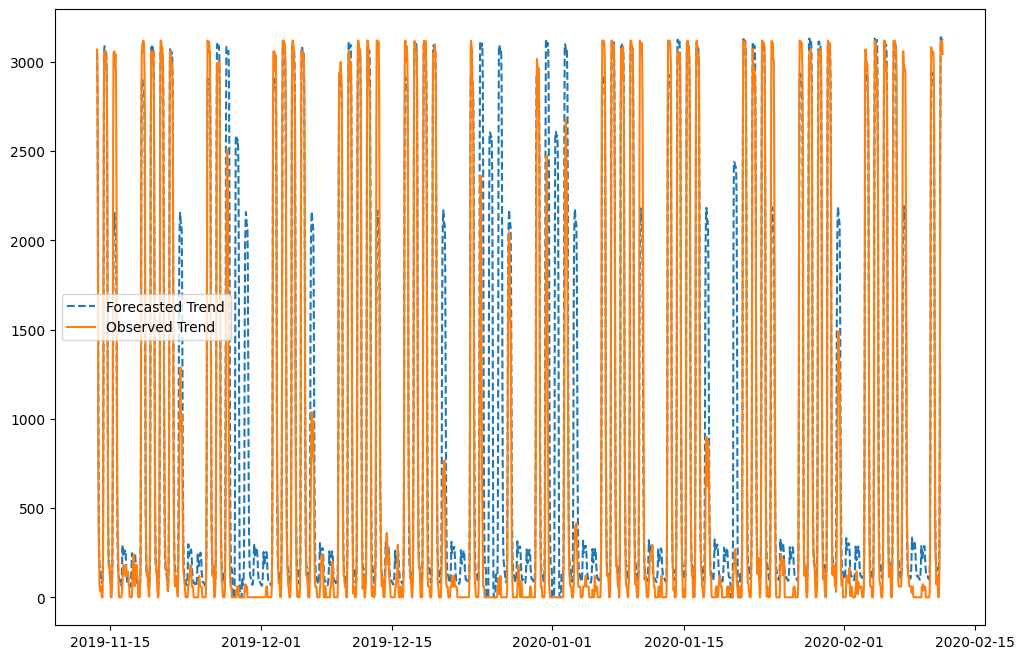

In [22]:
# Plot the forecast 
#plt.plot(stl_input_df.index[-forecast_horizon:], stl_input_df[-forecast_horizon:], label='Observed Trend')
plt.plot(forecast_index, forecast, label='Forecasted Trend', linestyle='--')
plt.plot(forecast_index, df1_test['total minutes of parking'][:forecast_horizon], label='Observed Trend')
plt.legend()
plt.show()

## Forecast | Site 2

In [23]:
def predict_trend_df2(stl_trend, forecast_horizon, degree=3):

    X = np.arange(0, len(stl_trend))
    y = stl_trend

    lin_reg_df = pd.DataFrame({'Hours': X, 'Trend':y})
        
    X = lin_reg_df[['Hours']].values
    y = lin_reg_df['Trend'].values

    # Generate polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    poly_reg_model = LinearRegression().fit(X_poly,y)

    future_time = np.arange(len(stl_trend), len(stl_trend) + forecast_horizon).reshape(-1,1)
    future_time_poly = poly.transform(future_time)
    future_trend = poly_reg_model.predict(future_time_poly)

    return future_trend

In [24]:
# Define forecast horizon
forecast_horizon_df2 = 24*90
forecast_index_df2 = pd.date_range(start=df2_train.index[-1], periods=forecast_horizon_df2 + 1, freq="h")[1:]

# Define holidays for forecast horizon
exog_holidays = forecast_index_df2.to_series().apply(lambda x: 1 if x in us_holidays else 0)

# Forecast residuals
residual_model_df2 = sarimax_result_df2
forecast_residual_df2 = residual_model_df2.forecast(steps=forecast_horizon_df2, exog=exog_holidays)

# Forecast weekly pattern
forecast_weekly_df2 = stl_seasonal_w_df2[-168:] 
forecast_weekly_df2 = np.tile(forecast_weekly_df2, int(np.ceil(forecast_horizon_df2 / 168)))[:forecast_horizon_df2]

# Forecast trend 
forecast_trend_df2 = predict_trend_df2(stl_trend_df2, forecast_horizon_df2, 1)

forecast_df2 = forecast_residual_df2 + forecast_weekly_df2 + forecast_trend_df2
forecast_df2 = forecast_df2.clip(lower=0)

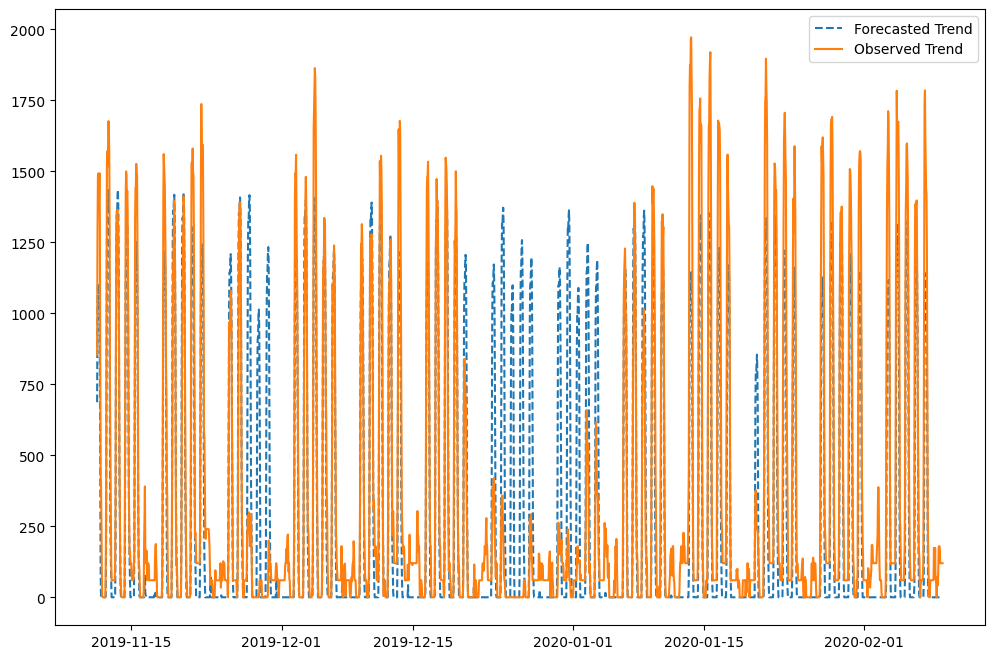

In [25]:
# Plot the forecast 
#plt.plot(stl_input_df.index[-forecast_horizon:], stl_input_df[-forecast_horizon:], label='Observed Trend')
plt.plot(forecast_index_df2, forecast_df2, label='Forecasted Trend', linestyle='--')
plt.plot(forecast_index_df2, df2_test['total minutes of parking'][:forecast_horizon_df2], label='Observed Trend')
plt.legend()
plt.show()

# Evaluation

In [26]:
def evaluate(data, forecast, forecast_horizon):    
    # Example ground truth (actual values)
    actual = data[:forecast_horizon]
    forecast = forecast[:forecast_horizon]

    # Compute errors
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)

    print(f"MAE: {mae:.3f}")
    print(f"MSE: {mse:.3f}")

In [28]:
evaluate(df1_test[['total minutes of parking']], forecast, forecast_horizon)
evaluate(df2_test[['total minutes of parking']], forecast_df2, forecast_horizon_df2)

MAE: 248.998
MSE: 281940.750
MAE: 154.974
MSE: 70271.124
